# Implementation of a SQP for nonlinear optimal control
The goal of this exercise is to implement a SQP solver to solve a nonlinear optimal control problem.

Consider the pendulum below 

<img src='pendulum.png' width="150">

Assuming $m=l=1$, The dynamics of this pendulum is
$$\ddot{\theta} = u - g \sin\theta$$
which can be discretized with the following dynamics
$$\begin{align}\theta_{n+1} &= \theta_n + \Delta t \omega_n\\ 
\omega_{n+1} &= \omega_n + \Delta t (u_n - g \sin\theta_n)\end{align}$$
where $\theta_n$ is the angle of the pendulum with respect to the vertical at time step $n$ and $\omega_n$ its angular velocity. We will use $\Delta t = 0.01$.
The pendulum starts at configuration $\theta_0 = \omega_0 = 0$, i.e. all the way down with zero velocity and we would like to find
an optimal control that will bring it up to $\theta=\pi$ with zero velocities.

To get the pendulum to do this movement, we write the following optimal control problem
$$\begin{align}
& \min_{\theta_n, \omega_n, u_n} \sum_{n=0}^{300} 10(\theta_n - \pi)^2 + 0.1\omega_n^2 + 0.1u_n^2\\
\textrm{subject to}\ \ & \theta_{n+1} = \theta_n + \Delta t \ \omega_n \\
& \omega_{n+1} = \omega_n + \Delta t\ (u_n - g \sin\theta_n)\\
& \theta_0 = \omega_0 = 0
\end{align}$$

## Question 1: write a SQP solver to solve this problem
To do so, please follow these steps:
* Write down the algorithm (in words not in code), i.e. write all the steps you need to take
* Write (in Latex) the gradient of the running cost at a given guess $\bar{x} = [\bar{\theta}_0, \bar{\omega}_0, \bar{u}_0, \bar{\theta}_1, \bar{\omega}_1, \bar{u}_1, \dots, \bar{\theta}_{300}, \bar{\omega}_{300}, \bar{u}_{300}]^T$, i.e. for given values $\bar{\theta}_n, \bar{\omega}_n, \bar{u}_n$ and implement a function that computes it
* Write (in Latex) the Hessian of the running cost at a given guess $\bar{x}$, i.e. for given values $\bar{\theta}_n, \bar{\omega}_n, \bar{u}_n$ and implement a function that computes it
* Assume that the Hessian of the constraints is 0 (i.e. ignore the second order derivatives of the constraints)
* Write (in Latex) a linear approximation of the constraints at a given guess $\bar{x}$ in a form $G(\bar{x}) \Delta x = g(\bar{x})$ (don't forget the constant terms in g) where $\Delta x$ represents a small variation around $\bar{x}$ and implement a function that computes both $G$ and $g$.
* Use these functions to construct the inner linear KKT system that you will solve using Numpy's solve function (this should resemble the KKT system you built in the first homework)
* Implement a function that computes the amount of constraint violation, i.e. the sum of the absolute values of all the constraints (i.e. assuming constraints of the form $c(x) = 0$ we want to compute $|c(x)|$).
* Implement a filter linear search to test if a step should be accepted. You will implement the (simplified) filter line search explained below.
* Terminate the algorithm when you either reached the maximum number of iterations (e.g. 100) or when the KKT optimality conditions $\nabla_x L$ and $\nabla_\lambda L$ are close to 0, e.g. $10^{-4}$.


Once you have a solution, make sure to check that it satisfies the constraints! You can also use the function ``pendulum.animate_robot`` to display the pendulum motion. Please answer the following questions:
1. How many iterations did it take?
2. Plot the solution (angle, velocity and control)
3. Plot the amont of constraint violation per iteration of the solver
4. Plot the cost per iteration of the solver
5. Plot $\alpha$ for each iteration of the solver

### (Simple) filter linear search
Once you have a potential step $p_x$ and associated candidate Lagrange multipliers $p_\lambda$ (from the ``solve`` of the KKT system), you need to find a step $\alpha$ to update your guess of the solution $x_{guess}$ and the Lagrange multipliers $\lambda_{guess}$. We will accept a step that either reduces the amount of constraint violation or reduces the cost.

Let's denote $f(x)$ the cost at $x$ and $|c(x)|$ the amount of constraint violation at $x$. Initialize the variable $f_{best} = \infty$ and $c_{best}=\infty$ at the beginning of the SQP. 

Then do the following during the line search.
1. Set $\rho$ to a number between 0 and 1 (e.g. 0.5) and set $\alpha = 1$
2. If $f(x_{guess} + \alpha p_x) < f_{best}$ then set $f_{best} \leftarrow f(x_{guess} + \alpha p_x)$ and accept the step

   Or 

   If $|c(x_{guess} + \alpha p_x)| < c_{best}$ then set $c_{best} \leftarrow |c(x_{guess} + \alpha p_x)|$ and accept the step
3. If the step was not accepted set $\alpha \leftarrow \rho \alpha$ and go back to Step 2.
4. If the step was accepted update the guess $x_{guess} \leftarrow x_{guess} + \alpha p_x$ and the Lagrange multipliers $\lambda_{guess} \leftarrow (1-\alpha)\lambda_{guess} + \alpha p_{lambda}$

## Question 2: write a SQP solver with inequality constraints
Modify your SQP solver in order to enforce the additional constraint $-4 \leq u_n \leq 4$. 

In this case you will need to use a QP solver instead of the ``solve`` function. Please use the [qpsolvers](https://pypi.org/project/qpsolvers/) library (use ``pip install qpsolvers`` to get the latest version 4.4.0 and use ``cvxopt`` as QP solver). You may access the Lagrange multipliers of the solution following [this example](https://qpsolvers.github.io/qpsolvers/quadratic-programming.html#dual-multipliers).

Update the convergence checks accordingly (using the KKT condition for the nonlinear problem $\nabla_x L$). Also update the computation of the constraint violation by computing the amount of inequality constraint violation in absolute value (note that it should be zero when the constraint is satisfied).

Once you have a solution, make sure to check that it satisfies the constraints! You can also use the function ``pendulum.animate_robot`` to display the pendulum motion. Please answer the following questions:
1. How many iterations did it take?
2. Plot the solution (angle, velocity and control)
3. Plot the amont of constraint violation per iteration of the solver
4. Plot the cost per iteration of the solver
5. Plot $\alpha$ for each iteration of the solver
6. Compare this solution with the solution from Question 1. Are there any qualitative differences in the pendulum behavior? Did the solver converge faster or slower?

In [1]:
!pip install qpsolvers cvxopt

In [2]:
%matplotlib inline
#Importing necessary libraries

import numpy as np
import matplotlib.pyplot as plt
from qpsolvers import solve_qp, Problem, solve_problem
import pendulum

In [3]:
# dt is defined here
print(f'we use the following dt={pendulum.dt}')

# and g here
print(f'we use the following g={pendulum.g}')

# you can use this animate function to display what the pendulum would do for a given sequence of control
N = 300
controls = np.zeros((N,1))
x_init = np.array([[1.0],[0.]])
pendulum.animate_robot(x_init, controls.T)

we use the following dt=0.01
we use the following g=9.81


<source type="video/mp4" src="data:video/mp4;base64,AAAAIGZ0eXBNNFYgAAACAE00ViBpc29taXNvMmF2YzEAAAAIZnJlZQAAUQVtZGF0AAACrwYF//+r
3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE2NCByMzEwOCAzMWUxOWY5IC0gSC4yNjQvTVBF
Ry00IEFWQyBjb2RlYyAtIENvcHlsZWZ0IDIwMDMtMjAyMyAtIGh0dHA6Ly93d3cudmlkZW9sYW4u
b3JnL3gyNjQuaHRtbCAtIG9wdGlvbnM6IGNhYmFjPTEgcmVmPTMgZGVibG9jaz0xOjA6MCBhbmFs
eXNlPTB4MzoweDExMyBtZT1oZXggc3VibWU9NyBwc3k9MSBwc3lfcmQ9MS4wMDowLjAwIG1peGVk
X3JlZj0xIG1lX3JhbmdlPTE2IGNocm9tYV9tZT0xIHRyZWxsaXM9MSA4eDhkY3Q9MSBjcW09MCBk
ZWFkem9uZT0yMSwxMSBmYXN0X3Bza2lwPTEgY2hyb21hX3FwX29mZnNldD0tMiB0aHJlYWRzPTEy
IGxvb2thaGVhZF90aHJlYWRzPTIgc2xpY2VkX3RocmVhZHM9MCBucj0wIGRlY2ltYXRlPTEgaW50
ZXJsYWNlZD0wIGJsdXJheV9jb21wYXQ9MCBjb25zdHJhaW5lZF9pbnRyYT0wIGJmcmFtZXM9MyBi
X3B5cmFtaWQ9MiBiX2FkYXB0PTEgYl9iaWFzPTAgZGlyZWN0PTEgd2VpZ2h0Yj0xIG9wZW5fZ29w
PTAgd2VpZ2h0cD0yIGtleWludD0yNTAga2V5aW50X21pbj0xMCBzY2VuZWN1dD00MCBpbnRyYV9y
ZWZyZXNoPTAgcmNfbG9va2FoZWFkPTQwIHJjPWNyZiBtYnRyZWU9MSBjcmY9MjMuMCBxY29tcD0w
LjYwIHFwbWluPTAgcXBtYXg9NjkgcXBzdGVwPTQgaXBfcmF0aW89MS40MCBhcT0xOjEuMDAAgAAA
DyVliIQAEP/+94G/MstfIrrJcfnnfSyszzzkPHJdia640AAAAwAAAwABR4e1643dg1tJ0AAAGsAD
pCLH/2+kONwANdenHSEFz8V9D0Huo6ra97jI0pgHWEgrm6XJ7eYN6T82kB9cDqoIFcQ1W8kYaaar
yB7R9dic4xvVnQpgkTkdJZH7yx7IyIimVgTUYPxFhDkBW+UMQNi3powsubwa8KN+BHTvqeuCVs4q
TK8Sutw9A6fePtWv8tSIuP258+p2cIDR/HoC502qtOvrz43hPJ3RUUchP/jkMpYOAy1Lq6sK90AL
oF/Oz4Y1ENQ0i2f1glYXnTFd9k3tViIdvhb8Obtv7u7iLxCIv9vzQG8cc1UVLjaVsH7rZq4NjwTW
zIbquJdq7N0QwKdYTv0dyhzo4lpN0IKSGmskBpHukKkYODpIi3Vt9jEbjUQiIN79vvT1AmUFW3kV
uJLOParcQoDssxoDtSaQ9lJ/bFa/OrnXXJspTKr+GKYKpYMHoFtBuZJabf0RTNFmbHGicKkwSFLG
3GJ8DhJrbEzxFl6Lc9K4QnQRIAcDrxR9qjwoW5DZnDILQfpVj8xC/OZoMpMmpeKRDqfWMFCjR1sI
3/hyOiIB3xX7wED7Ck154nWEZ3TPA4JgOcmE399kbSPnSNONN0uUJA0KamAETh9wR6FPvxx991l5
JmF0W5xysqdgb0Y3dQv5Ft5N+P/XB+Rm90F73EmjikEYA+v/6bTKQqYFLQ9xueuilsQQ4btK9AAA
AwAAAwAAAwAFRN8tVETrda7twwxRPwJ65LZSBmRudwS5Nr9dzQkmYIjWPpugpyIXXPIapdlKQLIV
BmJaiIB2BnSDmisMTggTqQjpwJkDr0voz3pdlAcfQl782WVgTrWGpLGD6hwIsqDybvx12tZl/8FS
qbOijOECAIn+iqvJ4KWshXyA/4qsDe4dx788S67CoBiMYfcZLaGWECMJ4bAyEuvh/pOeLmTMfsd9
frOdPvTdOEk8XdHnQZiMq2ocfDzuB8eyQRwd/1e7M1uoxkuV1lHXRUFuVM2Ad0lADWo7w9Y4TUgO
Px0dY9q4uDltGCpS/sf8D15AqCPkO//g7liN9dzpl0s11AcNDFYSPMGBK+Zew/7IPg7pniIjZ/WF
WwTkksWIO60w0APXpG+U4tmQdE21bCxo/ToF6mH/62klT56RbEJNeWXefscA9Qb0J/Qul0OTYjjd
PBxi9TnB6mEQCxPfWhI3BwdlSREJ1Nq6W81IcaI9WYAC+IrOMeohADi9HZdwQKoLtupbKeBJNRFC
Ro/8eeTWEyI8YUJEjjoyQwOfv6IEksx+Wm6ZArj+lRUoQieC+OG6IAVmkhaMbEA3Zl2StFtGYXbl
Nbl+DwNBXBJo/PAxt8UKObdT182hzOktc+/EvZ89yBbuDmoXZKjfbEiT+P2bt+O/KPr02NvRmMyT
kFhg2BLYOTKzALafFVOwzURa3fI8WRkftTeFyJ9njwLeRiI/xaaIC7cDdSFqV2TazHkJeaUFSx/v
MQut7HWYfWYbkuM1FRVuEQGRd6eboATF7RemOfirytMQ67g4VtT+0Gj0cHTEe5nmCm7XrNrq0W00
A2TTUM2rHtWiJDilGAUWNhSlmnCA0+eNQ9fSmy6Q0ZevtlmB5a5VBlYsFhRArKxl1wo565awVYR1
DOraME5070tpDspcXX+rrg529gJkG97jxh3CQESCQl2jd06bgNRX6WCjQ8vSvSmb8SNnl/z/ZNeP
yv2vj2bsL5r3FMfdyiE477GvI/xK1Jspe9WTWqFKhcPcaNruMUNFcVozYqclLBdEx1SFp4DzGPgv
gdcNyZOTW4mndtNW2bpNg7vMRsFHwvBIHIp77tUALRVFyY0d9kFBvQXsI5H82zbnBR/qKyyCeKU9
R63dTbhnDctudqNawM8hwl7JnhTQUg9kQGUF1VOAnBcr297kKayH/82zy9S5bslSWd51ZVExEHH9
LgCT+RZcJk91gaiGyKT1MGggBV4BwbyQEOIr2IG4rhoE2xmoL8MCxp2t0OQx09ErywE3jRmdlVVm
Qn8lZpyhmLyOlVP8CcNn/O4JXis5x+OFr8gVrmWCu4wfStdaDR45HKIn+8izUCgw9UT4jcPyRvjr
gmBsr6KeKoIDbbjIX3JVe5d5DC5BX3dnBelwkKZ4aTBzfnfosgsUMe2McljjdLvQeqU1AJQPY1OE
qzDZokNITYMCJsdB8KmqCFYO2X8bgcNdkiGv+Fq3Z/WibfAsycp8zX1ytAJ6Q4mFD1YTLGWFRKUM
DzAgWDu+pFsqEe39b/lk778+upnFKWoZZH8YJMRrfjXa2Q7/Tr8Y5vHXtvhgMYRHyIUePtesqwMb
SrKFWiARQ5Oz+DMXwJQe/MVqxqP+rV/K5+C278j62Fd1iLqPD++9GsPdRd3xE2sXcaR7g0HeLnQc
Z7koCbOAuehO9VH7VTCD+JZtn3lh5aYdVNyQR29lrQ/r2H8aI6igRJCwzdzChrLACVpCSDpAyB6N
aA11hwNn+ckusw3p4hg23WTCRTPbw7bwOgzZ7hG6X+2cSLZN11iFCp8kZvyFyhK7ulqq9/yadkC6
zHse8lQcQH6D40Sy8dt+Y3OhmNHIufAhJ9BPhIV3mjONA16u9JeazNnFFPskyR+WGFaa+VcGHpMB
APJMMZKiu7ek05GhN4q88Wkw19acMg7LNLliwmeM7xKdNWYek3FPyllwdiq3r4ERiCwRIzF3ezdM
uFoiF21I2giPqWce7ead3ldd8j/pEWD/cXO9TwlpL8RPYBKhz0ahyAQmAE8MRCKt0FYLjPRbS7T0
BdoMdM3FPddL1/GA0E1A60lGMq4gIzCV5w4OCcy4uyisCE+tqtGzZrIXIVcuf3Z3j1ktWQXQs9/K
A5v98vNc7O/SO5E7e3wk7

In [4]:
# Constants
g = 9.81
dt = 0.01
theta_target = np.pi
xdim = 2  # State dimension
udim = 1  # Control input dimension
nvars = (N + 1) * xdim + (N + 1) * udim  # Total number of variable

# Cost weights
Q_theta = 10.0
Q_omega = 0.1
R_u = 0.1

In [5]:
# Defining cost function
def cost_function(theta, omega, u, N):
    J = 0
    for n in range(N + 1):
        J += Q_theta * (theta[n] - theta_target)**2 + Q_omega * omega[n]**2 + R_u * u[n]**2
    return J

In [6]:
# Computing gradient of cost function
def cost_gradient(theta, omega, u, N):
    grad_theta = np.zeros(N + 1)
    grad_omega = np.zeros(N + 1)
    grad_u = np.zeros(N + 1)
    gradient = np.zeros(3 * (N + 1))  # final gradient array
    
    for n in range(N + 1):
        grad_theta[n] = 2 * Q_theta * (theta[n] - theta_target)
        grad_omega[n] = 2 * Q_omega * omega[n]
        grad_u[n] = 2 * R_u * u[n]
        
        # Inserting values in interleaved format
        gradient[3 * n] = grad_theta[n]
        gradient[3 * n + 1] = grad_omega[n]
        gradient[3 * n + 2] = grad_u[n]
    
    return gradient

In [7]:
# Creating the block diagonal Hessian matrix
def cost_hessian(N):
    # Define the base block for one time step
    base_block = np.array([
        [2 * Q_theta, 0, 0],
        [0, 2 * Q_omega, 0],
        [0, 0, 2 * R_u]
    ])
    
    # Creating block diagonal matrix by repeating the base block N times
    H = np.kron(np.eye(N + 1), base_block)  # np.kron replicates base block along the diagonal
    return H               

In [8]:
# Dynamics Jacobian
def dynamics_jacobian(theta, omega, u, N):
    G = np.zeros((2 * (N + 1), 3 * (N + 1)))  # G - Jacobian matrix
    g_vec = np.zeros(2 * (N + 1))  # Constraint violation vector

    for n in range(N + 1):
        # Jacobian G - dynamics equations
        # Calculation of G for this time step
        J_n = np.array([[1, dt, 0],
                    [-dt * g * np.cos(theta[n]), 1, dt]])
    
        # Jacobian block correct positioning
        G[2 * n : 2 * n + 2, 3 * n : 3 * n + 3] = J_n
        
    for n in range(0, 2 * N, 2):
        # Constraint violation vector
        n_ot = int(n / 2)
        g_vec[n] = theta[n_ot] + (dt * omega[n_ot]) - theta[n_ot + 1]
        g_vec[n + 1] = omega[n_ot] + (dt * (u[n_ot] - g * np.sin(theta[n_ot]))) - omega[n_ot + 1]

    return G, g_vec

In [9]:
# Dunamics Jacobian for Inequalities 
def ineq_jacobian(theta, omega, u, N):
    # Initializing H matrix and h_vec for inequality constraints
    H = np.zeros((2 * (N + 1), 3 * (N + 1)))  # H matrix to enforce u bounds
    h_vec = np.zeros(2 * (N + 1))             # Constraint violation vector

    for n in range(N + 1):
        # Setting up the inequality constraints for each time step
        # constraint u >= -4, setting up -u <= 4
        H[2 * n, 3 * n + 2] = -1              # -u in constraint coefficient
        h_vec[2 * n] = u[n] + 4               # -u <= 4 as u + 4 ≥ 0

        # constraint u <= 4
        H[2 * n + 1, 3 * n + 2] = 1           # u in constraint coefficient
        h_vec[2 * n + 1] = 4 - u[n]           # u <= 4 as 4 - u ≥ 0

    return H, h_vec

In [10]:
# Computing amount of constraint violation
def compute_constraint_violation(g_vec):
    return np.sum(np.abs(g_vec))

In [11]:
# QUESTION 1
np.random.seed(15) # Consistent randomness

N = 300 # time steps for Question 1

# Initializing theta, omega, u
theta = np.random.uniform(0, theta_target, N + 1)
omega = np.zeros(N + 1)
u = np.sin(np.linspace(0, 3 * np.pi, N + 1))

# Initial state (theta_0, omega_0)
theta[0] = 0
omega[0] = 0

In [12]:
# Initializing convergence criteria
max_iter = 350
tol = 1e-4
f_best = np.inf
c_best = np.inf

# Initializing lists for plotting graphs later
costs = []
constraint_violations = []
alphas = []

lambda_guess = np.full(2 * (N + 1), 4)

# SQP algorithm with Lagrange multipliers (KKT system)
for iteration in range(max_iter):
    # Computing gradient, Hessian, and dynamics jacobian
    grad = cost_gradient(theta, omega, u, N)
    H = cost_hessian(N)

    G, g_vec = dynamics_jacobian(theta, omega, u, N)

    # Formulating the KKT system
    nconstraints = 2 * (N + 1)
    KKT = np.zeros((nvars + nconstraints , nvars + nconstraints))
    # H in top-left block
    KKT[0:nvars, 0:nvars] = H
    # G in bottom-left block
    KKT[nvars:, 0:nvars] = G
    # G.T in top-right block
    KKT[0:nvars, nvars:] = G.T

    KKT_rhs = - np.concatenate([grad, g_vec])  # Right-hand side of KKT system
    sol = np.linalg.solve(KKT, KKT_rhs)
    p_x = sol[:3 * (N + 1)]  # Primal step (theta, omega, u)
    p_lambda = sol[3 * (N + 1):]  # Dual step (Lagrange multipliers)
    # Here p_lambda is for the next lambda i.e. lambda_{k+1}
    
    # Line search with filter
    alpha = 1.0
    rho = 0.95
    while True:
        # Step in the direction of p_x
        theta_new = theta + alpha * p_x[0 : 3 * (N + 1) : 3]
        omega_new = omega + alpha * p_x[1 : 3 * (N + 1) : 3]
        u_new = u + alpha * p_x[2 : 3 * (N + 1) : 3]
        
        # Ensuring theta_new remains within [-pi, pi]
        theta_new = (theta_new + np.pi) % (2 * np.pi) - np.pi

        # Computing new cost and constraint violation
        cost_new = cost_function(theta_new, omega_new, u_new, N)
        _, g_new = dynamics_jacobian(theta_new, omega_new, u_new, N)
        constraint_violation_new = compute_constraint_violation(g_new)

        # Accepting step if cost improves or constraint violation improves
        if cost_new <f_best:
            f_best = cost_new
            accept = True
        elif constraint_violation_new < c_best:
            c_best = constraint_violation_new
            accept = True 
        else:
            accept = False

        if accept:
            # Update solution, Lagrange multipliers, and plotting data terms
            theta = theta_new
            omega = omega_new
            u = u_new
            lambda_guess_new = p_lambda # Lagrange multipliers
            break
        else:
            # Reduce step size
            alpha *= rho

    costs.append(cost_new)
    constraint_violations.append(constraint_violation_new)
    alphas.append(alpha)

    lagrangian_grad = grad + G.T @ lambda_guess  # This is ∇x L

    lambda_guess = lambda_guess_new
    
    # Primal optimality: checking ∇x L ≈ 0
    primal_optimality = np.linalg.norm(lagrangian_grad)
    # Dual optimality: checking ∇λ L ≈ 0, which means g_vec ≈ 0
    dual_optimality = np.linalg.norm(g_vec)

    # Tracking status every 50 steps
    if (iteration + 1) % 50 == 0:
        print(f"Itr: {iteration + 1}, Cost: {round(cost_new,2)}, Constraint Vio.: {round(constraint_violation_new, 2)}, Alpha: {alpha}, Primal Opt.: {round(primal_optimality, 7)}, Dual Opt.: {round(dual_optimality,16)}")
    
    # Checking for convergence
    if primal_optimality < tol and dual_optimality < tol:
        print(f"--- CCONVERGED IN {iteration + 1} ITERATION(S)! ---")
        print(f"Itr: {iteration + 1}, Cost: {round(cost_new,2)}, Constraint Vio.: {round(constraint_violation_new, 2)}, Alpha: {alpha}, Primal Opt.: {round(primal_optimality, 7)}, Dual Opt.: {round(dual_optimality,16)}")
        break

Itr: 50, Cost: 19775.74, Constraint Vio.: 118.02, Alpha: 0.95, Primal Opt.: 3.6630067, Dual Opt.: 7.33904302124336
Itr: 100, Cost: 41251.55, Constraint Vio.: 85.16, Alpha: 0.95, Primal Opt.: 1.9389521, Dual Opt.: 6.607017761177605
Itr: 150, Cost: 29145.4, Constraint Vio.: 70.83, Alpha: 1.0, Primal Opt.: 0.1947472, Dual Opt.: 6.08723637211401
Itr: 200, Cost: 11105.67, Constraint Vio.: 54.73, Alpha: 0.95, Primal Opt.: 1.7985305, Dual Opt.: 5.7660325001557835
Itr: 250, Cost: 17279.38, Constraint Vio.: 37.11, Alpha: 1.0, Primal Opt.: 0.0730861, Dual Opt.: 5.494810059963609
Itr: 300, Cost: 31330.93, Constraint Vio.: 19.68, Alpha: 1.0, Primal Opt.: 0.0678081, Dual Opt.: 4.834542179077825
--- CCONVERGED IN 320 ITERATION(S)! ---
Itr: 320, Cost: 34171.09, Constraint Vio.: 0.0, Alpha: 1.0, Primal Opt.: 1.7e-06, Dual Opt.: 5.47876270415e-05


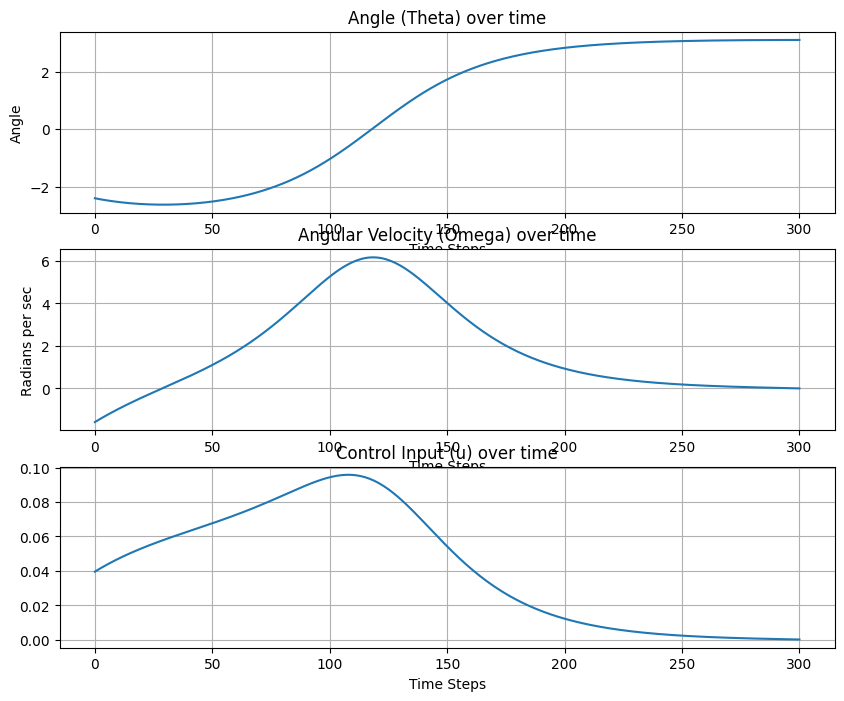

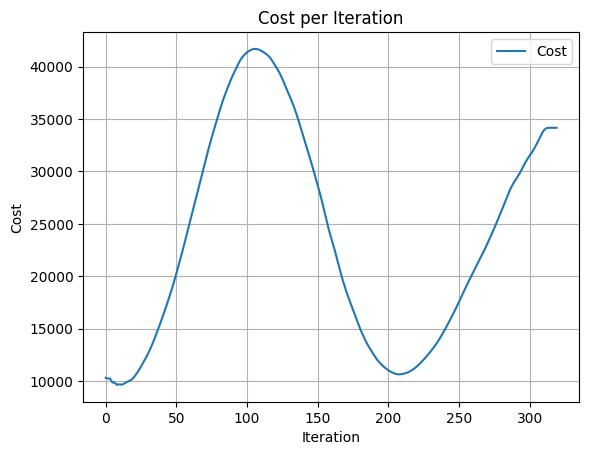

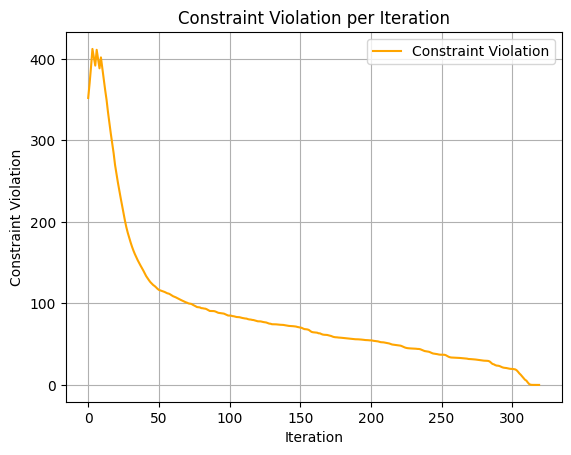

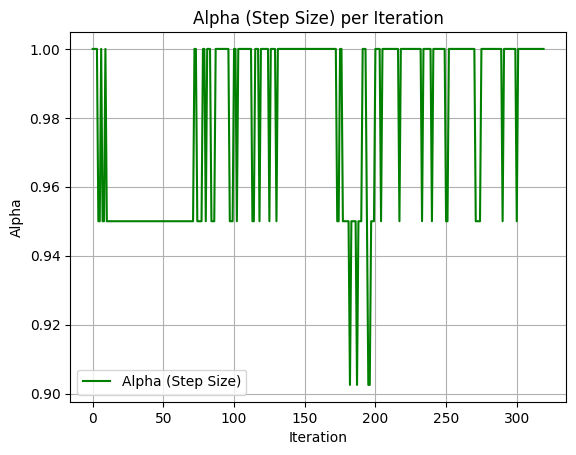

In [13]:
# Plotting the results for Question 1
plt.figure(figsize=(10, 8))

# theta over time
plt.subplot(3, 1, 1)
plt.plot(theta)
plt.title('Angle (Theta) over time')
plt.xlabel('Time Steps')
plt.ylabel('Angle')
plt.grid(True)

# omega over time
plt.subplot(3, 1, 2)
plt.plot(omega)
plt.title('Angular Velocity (Omega) over time')
plt.xlabel('Time Steps')
plt.ylabel('Radians per sec')
plt.grid(True)

# u (control input) over time
plt.subplot(3, 1, 3)
plt.plot(u)
plt.title('Control Input (u) over time')
plt.xlabel('Time Steps')
plt.ylabel('')
plt.grid(True)

# cost per iteration
plt.figure()
plt.plot(costs, label='Cost')
plt.title('Cost per Iteration')
plt.xlabel('Iteration')
plt.ylabel('Cost')
plt.grid(True)
plt.legend()

# constraint violation per iteration
plt.figure()
plt.plot(constraint_violations, label='Constraint Violation', color='orange')
plt.title('Constraint Violation per Iteration')
plt.xlabel('Iteration')
plt.ylabel('Constraint Violation')
plt.grid(True)
plt.legend()

# alpha per iteration
plt.figure()
plt.plot(alphas, label='Alpha (Step Size)', color='green')
plt.title('Alpha (Step Size) per Iteration')
plt.xlabel('Iteration')
plt.ylabel('Alpha')
plt.grid(True)
plt.legend()

# plt.tight_layout()
plt.show()

In [14]:
# Animating pendulum motion (Question 1)
pendulum.animate_robot(np.array([[theta[0]], [omega[0]]]), u.reshape(1, -1))

<source type="video/mp4" src="data:video/mp4;base64,AAAAIGZ0eXBNNFYgAAACAE00ViBpc29taXNvMmF2YzEAAAAIZnJlZQAARwBtZGF0AAACrwYF//+r
3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE2NCByMzEwOCAzMWUxOWY5IC0gSC4yNjQvTVBF
Ry00IEFWQyBjb2RlYyAtIENvcHlsZWZ0IDIwMDMtMjAyMyAtIGh0dHA6Ly93d3cudmlkZW9sYW4u
b3JnL3gyNjQuaHRtbCAtIG9wdGlvbnM6IGNhYmFjPTEgcmVmPTMgZGVibG9jaz0xOjA6MCBhbmFs
eXNlPTB4MzoweDExMyBtZT1oZXggc3VibWU9NyBwc3k9MSBwc3lfcmQ9MS4wMDowLjAwIG1peGVk
X3JlZj0xIG1lX3JhbmdlPTE2IGNocm9tYV9tZT0xIHRyZWxsaXM9MSA4eDhkY3Q9MSBjcW09MCBk
ZWFkem9uZT0yMSwxMSBmYXN0X3Bza2lwPTEgY2hyb21hX3FwX29mZnNldD0tMiB0aHJlYWRzPTEy
IGxvb2thaGVhZF90aHJlYWRzPTIgc2xpY2VkX3RocmVhZHM9MCBucj0wIGRlY2ltYXRlPTEgaW50
ZXJsYWNlZD0wIGJsdXJheV9jb21wYXQ9MCBjb25zdHJhaW5lZF9pbnRyYT0wIGJmcmFtZXM9MyBi
X3B5cmFtaWQ9MiBiX2FkYXB0PTEgYl9iaWFzPTAgZGlyZWN0PTEgd2VpZ2h0Yj0xIG9wZW5fZ29w
PTAgd2VpZ2h0cD0yIGtleWludD0yNTAga2V5aW50X21pbj0xMCBzY2VuZWN1dD00MCBpbnRyYV9y
ZWZyZXNoPTAgcmNfbG9va2FoZWFkPTQwIHJjPWNyZiBtYnRyZWU9MSBjcmY9MjMuMCBxY29tcD0w
LjYwIHFwbWluPTAgcXBtYXg9NjkgcXBzdGVwPTQgaXBfcmF0aW89MS40MCBhcT0xOjEuMDAAgAAA
DqVliIQAEP/+94G/MstfIrrJcfnnfSyszzzkPHJdia640AAAAwAAAwABR4e1643dg1tJ0AAAGsAD
pCLH/2+kONwANdenHSEFz8V9D0Huo6ra97jI0pgHWEgrm6XJ7eYN6T82kB9cDqoIFcQ1W8kYaaar
yB7R9dic4xvVnQpgkTkdJZH7yx7IyIimVgTUYPxFhDkBW+UMQNi3powsubwa8KN+BHTvqeuCVs4q
TK8Sutw9A6fePtWv8tSIuP258+p2cIDR/HoC502qtOvrz43hPJ3RUUchP/jkMpYOAy1Lq6sK90AL
oF/Oz4Y1ENQ0i2f1glYXnTFd9k3tViIdvhb8Obtv7u7iLxCIv9vzQG8cc1UVLjaVsH7rZq4NjwTW
zIbquJdq7N0QwKdYTv0dyhzo4lpN0IKSGmskBpHukKkYODpIi3Vt9jEbjUQiIN79vvT1AmUFW3kV
uJLOParcQoDssxoDtSaQ9lJ/bFa/OrnXXJspTKr+GKYKpYMHoFtBuZJabf0RTNFmbHGicKkwSFLG
3GJ8DhJrbEzxFl6Lc9K4QnQRIAcDrxR9qjwoW5DZnDILQfpVj8xC/OZoMpMmpeKRDqfWMFCjR1sI
3/hyOiIB3xX7wED7Ck154nWEZ3TPA4JgOcmE399kbSPnSNONN0uUJA0KamAETh9wR6FPvxx991l5
JmF0W5xysqdgb0Y3dQv5Ft5Gq//yqvzFgnKcscLkejJBMpCXgUVD3G566KW4Bfhrlv0AAAMAACUw
0BI3BHB5niBQoO6h8AXtNzHHhnkMr61gq7BJMO7BBU/J0HZKorPcVO933MyX3fwnSo2oS85vkoAU
N7fLAl8wN9+CJnimR5sB8PezZBbQFcZRcbYmhddea3Kwy5fOt2g3iK6FoDY1KjwZC7B6T7WP7plx
bh1CDivBFfL1Fa4A4KHk9eADOFFrbF+KqCvE3o1j5JF7wzL0uVFX44Q9V2iwWLIEHeMUr6gIT6Wu
6k+GcbOKbVnkWr9BEUE6vXQfOn2w5gd9v9Qz75AWd3Jf++iyRgVdbIu2EcIAl8koB9jebQIsGu1y
LGp7J5pVAQyJcP+WBwgnVacyzaIwi4UJjwoFxPmdxkRNyYB+upPFwmOZXDdy2WQDa06YR6F5RGOF
ORMiAZ7mY8ZVoj5MmTRWR1XlFu9rmIVKJ88Y0bFSjHc/ybq121ycD5qA8yjL8EpHzH/t0MsIEYTw
2SzO3wzIYUzyL/pu2Mgu9IKCPrnu9J8XdHnQZgcxBWHHw87gfHskEbKv2nwcZEjtFoKrKKpaTAfp
LhQB02MBdD6GsaBgM0hQU8waY8XdCXvpfnchaJ/aQWQlaZbZNzkRPjCFJpsIc+AKQCrnd95Zf1X6
IF9/P1vlPX2zVd+EQ8dPnS5BlRWFSdHCUY88+wvm/d3vAO7OeZS6ULNT2kyeOpn4pWBMn/xUVRvh
EoGoxChO3IZDLW0+Zb0JglcojRb4RDkzEeq47W0lAHA7YICL++dTTc1ai/joh9NTinjnbrmh2scJ
uKUAMndjYf2QGIFW5mBlBOsW6EG5RnJNy904LMI/tgoP1x795TeH07v6jsalUJRY9jxiYY3y0KIr
PCe1RnmIAAW7iNiBrdzrTpaVoBEcbi7tx69N6jRL/f0CO/5zcmiBuwbdj+kTln4vdobv50z1p7MG
6qT4q4l1zWF/ABQOc7P2DjVJLjXM0TXkUIYMSatHRRnZMxmtG0WMgtglvNnu8gqxOOFrISWUTx75
YFqf3uK05m+FZxHauN2DoR2TvcFEDwhZvSiAPiA9/odt9R3XaPJ2hnNrAAPU3XeWJ/EhOBm1c8PD
u9y50TU4zAFA9kNsZJC+pEtDBz7oV+U/+nZCDysveX69me7+/9jgA6KGkUI4I8popNVPdeGcz+hn
OUgpqrLpZN5oy+4UmwMI1f4o4VOt3+JJO+Fv63DyA80o1M5FquvwCC+NQtfqt5yVV7437X5zPuW7
TwT2Lmqo2Lru0wXlnrw+FYHSUi2ZYaHEwDJYOhqUXfqcPstRWwzkd8uJbbkSvoEp59pG4vxjE34t
lYS/REnkwYO3Z/Xd9Os8/ECEIcJxldZ5hftwIOISrREGFBV6XU5U2+nr1ksnyMC9gK9v0SZj18+f
5I/HtwirRJM5jyCBunQWfpFDe6EPPFG+3gyNxFqe7LF5VBjxgqfqUtFl9+Uhwcoy5MrLs2jVVZGk
46oxKsftfymTy1yIn01gThHYsIPRSt1n7H9ZQMiPbcNqbpZSQ3kFwpuvoff+AEUoT64OFsoQLseL
kDiMuJS2i4rhJeFzxArbmQhfprkZfgrU3Vn07JZLxkzblolT8yfgysWCwogVsfzf3oZi/7xQEVvC
blonHUWF4uZWG6f1/LWAhZVO+zAZjEtDWNgZI0JIZFakcDE29NUmLBO0byxEUSXREa5iEBI+T4wF
XmZo+Pva/9IQVACFeVLn+RmTzNv9maTywQp4eOejpMmHX3eQUrhVmwSbKVecw5EPhMP/+nhaBCxr
jM8CtDmvrZfArVycfs9/Y+/aeoZ/2ktrAVBfqA0ZwDrZUJBOAfmoxZMKDPQOhTE1xkvAAAADAAAD
A2yFXxu/UEv1kH8gvmRBpU9jBRPm2XS36B01ua9NKj+4z+l2Rlm4a2qawi0vawD2e7fmxivUl24X
x1LqASjmfOEx8cuSy8EvlOlhHZ5YItNjd9salkv8vrivhLUjKA0WfE0rgM6jHnCwi/r7+GDOwv74
62bWT8Bx0mnI0KE4b5TvxH1pulPnk9coexTrR2i2SmYekdd5i5d74/TnPcSHtFQ38FMxynoINKyG
b1ljurhe9bW6uwemOS205/7s7PxW/uarQR1RVq4llI+S4k0iTNGj/77rjJG9I1DW76zMVXBJ3A/d
M3Exuscx1QyuZ8Q7kc2P+

In [15]:
# QUESTION 2
import cvxopt
from cvxopt import matrix, solvers
# from qpsolvers import solve_qp, Problem, solve_problem - not working to return Lagrange multipliers
# The above library used cvxopt solver (same solver from qpsolvers) works

N = 500 # time steps for Question 2

np.random.seed(15) # Consistent randomness

# Initializing theta, omega, u
theta = np.random.uniform(0, theta_target, N + 1)
omega = np.zeros(N + 1)
u = np.sin(np.linspace(0, 3 * np.pi, N + 1))

# Initial state (theta_0, omega_0)
theta[0] = 0
omega[0] = 0

In [16]:
# Initializing convergence criteria
max_iter = 600
tol = 1e-4
f_best = np.inf
c_best = np.inf

# Initializing lists for plotting graphs later
constraint_violations = []
costs = []
alphas = []

# Bounds for control input
lb_u = -4 * np.ones(N + 1)
ub_u = 4 * np.ones(N + 1)

lambda_guess = np.full(2 * (N + 1), 4)
mu_guess = np.full(2 * (N + 1), 4)

# Modified SQP to handle control input bounds using cvxopt
for iteration in range(max_iter):
    # Computing gradient, Hessian, and dynamics jacobian
    grad = cost_gradient(theta, omega, u, N)
    P = cost_hessian(N)
    G_qp, g_qp = dynamics_jacobian(theta, omega, u, N)
    H, h_vec = ineq_jacobian(theta, omega, u, N)

    q = grad
    
    # Converting to cvxopt format
    P_cvxopt = matrix(P)
    q_cvxopt = matrix(q)
    G_cvxopt = matrix(H)
    h_cvxopt = matrix(h_vec)
    C_cvxopt = matrix(G_qp)
    d_cvxopt = matrix(-g_qp)

    # Solving using cvxopt QP solver - returns both primal and dual solutions
    sol = solvers.qp(P_cvxopt, q_cvxopt, G_cvxopt, h_cvxopt, C_cvxopt, d_cvxopt)

    # Extracting primal and dual solutions
    p_x = np.array(sol['x']).flatten()  # Primal step (theta, omega, u)
    p_lambda = np.array(sol['y']).flatten()  # Dual step (Lagrange multipliers for equality constraints)
    p_mu = np.array(sol['z']).flatten()  # Dual step (Lagrange multipliers for inequality constraints)
    # Here p_lambda and p_mu are for the next lambda i.e. lambda_{k+1} and mu_{k+1} respectively

    # Updating theta, omega, u
    alpha = 1.0
    rho = 0.95

    while True:
        # Step in the direction of p_x
        theta_new = theta + alpha * p_x[0 : 3 * (N + 1) : 3].flatten()
        omega_new = omega + alpha * p_x[1 : 3 * (N + 1) : 3].flatten()
        u_new = np.clip(u + alpha * p_x[2 : 3 * (N + 1) : 3].flatten(), lb_u, ub_u)
        
        # Ensuring theta_new remains within [-pi, pi]
        theta_new = (theta_new + np.pi) % (2 * np.pi) - np.pi

        # Computing new cost and constraint violation
        cost_new = cost_function(theta_new, omega_new, u_new, N)
        G_pq_new, g_pq_new = dynamics_jacobian(theta_new, omega_new, u_new, N)
        
        # violation for equality constraints from g_vec and inequality constraints from u
        total_constraint_violation_new = np.sum(np.abs(g_pq_new)) + np.sum(np.abs(np.clip(u_new - 4, 0, None)) + np.abs(np.clip(-4 - u_new, 0, None)))

        # Accepting step if cost improves or constraint violation improves
        if cost_new < f_best:
            f_best = cost_new
            accept = True
        elif total_constraint_violation_new < c_best:
            c_best = total_constraint_violation_new
            accept = True 
        else:
            accept = False

        if accept:
            # Update solution, Lagrange multipliers, and plotting data terms
            theta = theta_new
            omega = omega_new
            u = u_new
            lambda_guess_new = p_lambda # Lagrange multipliers
            mu_guess_new = p_mu
            break
        else:
            # Reduce step size
            alpha *= rho

    costs.append(cost_new)
    alphas.append(alpha)
    constraint_violations.append(total_constraint_violation_new)

    # Primal optimality: checking ∇x L ≈ 0
    primal_optimality = np.linalg.norm(grad + G_qp.T @ lambda_guess + H.T @ mu_guess) # Gradient of Lagrangian - ∇x L
    # Dual optimality: checking ∇λ L ≈ 0, which means g_vec ≈ 0
    dual_optimality = np.linalg.norm(g_qp)
    inequality_condition = np.linalg.norm(H.T @ mu_guess)

    lambda_guess = lambda_guess_new
    mu_guess = mu_guess_new
    
    # Tracking status every 50 steps
    if ((iteration + 1) % 50 == 0):
        print(f"Itr: {iteration + 1}, Cost: {round(cost_new,2)}, Constraint Vio.: {round(total_constraint_violation_new, 2)}, Alpha: {alpha}, Primal Opt.: {round(primal_optimality, 8)}, Dual Opt.: {round(dual_optimality, 8)}, Inequality Con.: {round(inequality_condition, 8)}")
        
    # Check for convergence using KKT conditions
    if primal_optimality < tol and dual_optimality < tol and inequality_condition < tol:
        print(f"--- CONVERGED IN {iteration + 1} ITERATION(S)! ---")
        print(f"Itr: {iteration + 1}, Cost: {round(cost_new,2)}, Constraint Vio.: {round(total_constraint_violation_new, 2)}, Alpha: {alpha}, Primal Opt.: {round(primal_optimality, 8)}, Dual Opt.: {round(dual_optimality, 8)}, Inequality Con.: {round(inequality_condition, 8)}")
        break

Itr: 50, Cost: 38255.08, Constraint Vio.: 193.24, Alpha: 0.95, Primal Opt.: 4.37794212, Dual Opt.: 8.82436991, Inequality Con.: 1.6e-07
Itr: 100, Cost: 89541.9, Constraint Vio.: 149.65, Alpha: 1.0, Primal Opt.: 0.17147607, Dual Opt.: 7.8662889, Inequality Con.: 1.5e-07
Itr: 150, Cost: 79872.19, Constraint Vio.: 125.04, Alpha: 1.0, Primal Opt.: 0.11848993, Dual Opt.: 6.2889188, Inequality Con.: 6e-08
Itr: 200, Cost: 40392.02, Constraint Vio.: 100.26, Alpha: 0.8573749999999999, Primal Opt.: 5.62095187, Dual Opt.: 5.5850331, Inequality Con.: 6e-08
Itr: 250, Cost: 32352.75, Constraint Vio.: 87.89, Alpha: 0.95, Primal Opt.: 0.07277945, Dual Opt.: 5.72349044, Inequality Con.: 7e-08
Itr: 300, Cost: 50483.13, Constraint Vio.: 68.08, Alpha: 0.95, Primal Opt.: 2.63399043, Dual Opt.: 4.33465043, Inequality Con.: 1.2e-07
Itr: 350, Cost: 65195.87, Constraint Vio.: 51.74, Alpha: 1.0, Primal Opt.: 0.05507303, Dual Opt.: 4.55333628, Inequality Con.: 0.0
Itr: 400, Cost: 53161.12, Constraint Vio.: 27.11

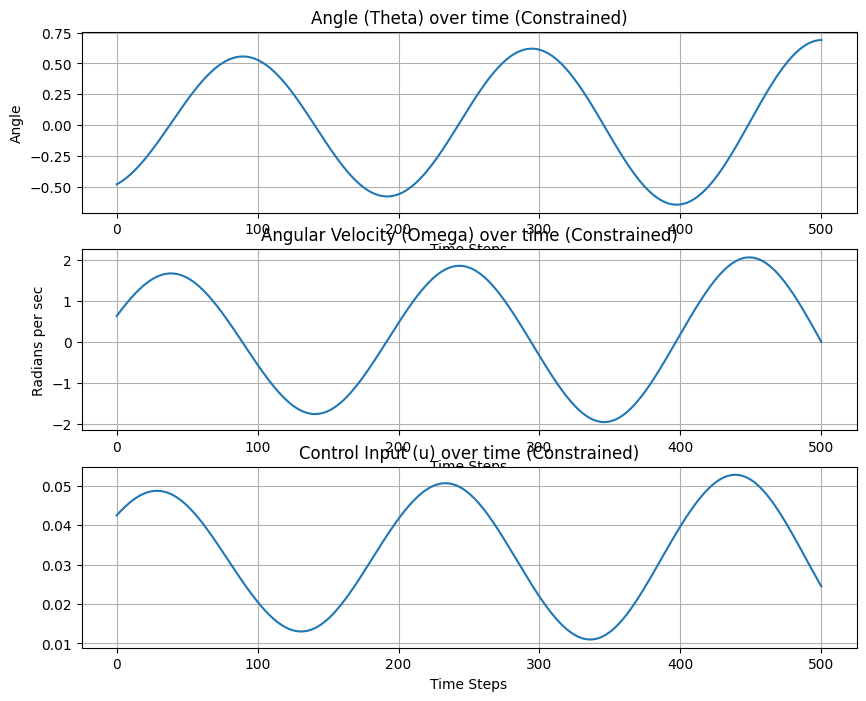

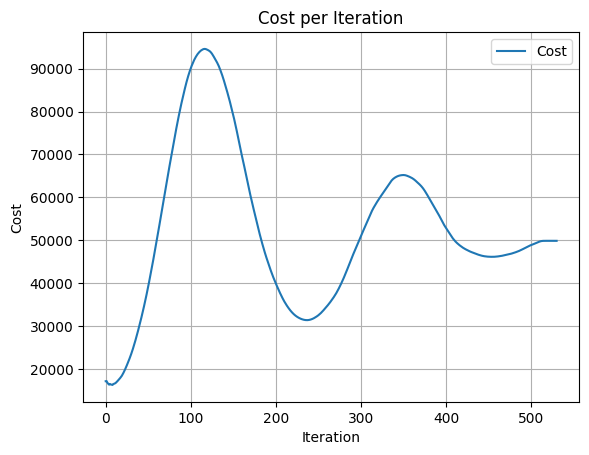

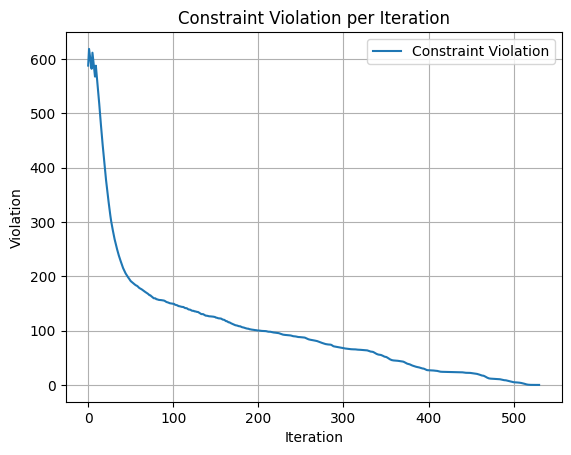

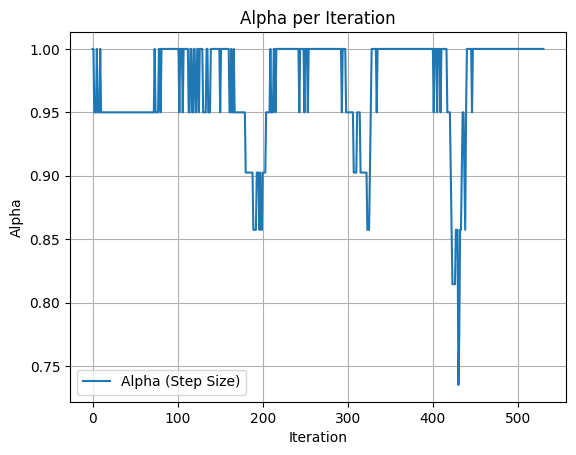

In [17]:
# Plotting results for Question 2
plt.figure(figsize=(10, 8))

# theta
plt.subplot(3, 1, 1)
plt.plot(theta)
plt.title('Angle (Theta) over time (Constrained)')
plt.xlabel('Time Steps')
plt.ylabel('Angle')
plt.grid(True)

# omega 
plt.subplot(3, 1, 2)
plt.plot(omega)
plt.title('Angular Velocity (Omega) over time (Constrained)')
plt.xlabel('Time Steps')
plt.ylabel('Radians per sec')
plt.grid(True)

# u (control input)
plt.subplot(3, 1, 3)
plt.plot(u)
plt.title('Control Input (u) over time (Constrained)')
plt.xlabel('Time Steps')
plt.ylabel('')
plt.grid(True)

# cost per iteration
plt.figure()
plt.plot(costs, label='Cost')
plt.title('Cost per Iteration')
plt.xlabel('Iteration')
plt.ylabel('Cost')
plt.grid(True)
plt.legend()

# constraint violation per iteration
plt.figure()
plt.plot(constraint_violations, label='Constraint Violation')
plt.title('Constraint Violation per Iteration')
plt.xlabel('Iteration')
plt.ylabel('Violation')
plt.grid(True)
plt.legend()

# alpha per iteration
plt.figure()
plt.plot(alphas, label='Alpha (Step Size)')
plt.title('Alpha per Iteration')
plt.xlabel('Iteration')
plt.ylabel('Alpha')
plt.grid(True)
plt.legend()

# plt.tight_layout()
plt.show()

In [18]:
# Animating pendulum motion (Question 2)
pendulum.animate_robot(np.array([[theta[0]], [omega[0]]]), u.reshape(1, -1))

<source type="video/mp4" src="data:video/mp4;base64,AAAAIGZ0eXBNNFYgAAACAE00ViBpc29taXNvMmF2YzEAAAAIZnJlZQAAag9tZGF0AAACrwYF//+r
3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE2NCByMzEwOCAzMWUxOWY5IC0gSC4yNjQvTVBF
Ry00IEFWQyBjb2RlYyAtIENvcHlsZWZ0IDIwMDMtMjAyMyAtIGh0dHA6Ly93d3cudmlkZW9sYW4u
b3JnL3gyNjQuaHRtbCAtIG9wdGlvbnM6IGNhYmFjPTEgcmVmPTMgZGVibG9jaz0xOjA6MCBhbmFs
eXNlPTB4MzoweDExMyBtZT1oZXggc3VibWU9NyBwc3k9MSBwc3lfcmQ9MS4wMDowLjAwIG1peGVk
X3JlZj0xIG1lX3JhbmdlPTE2IGNocm9tYV9tZT0xIHRyZWxsaXM9MSA4eDhkY3Q9MSBjcW09MCBk
ZWFkem9uZT0yMSwxMSBmYXN0X3Bza2lwPTEgY2hyb21hX3FwX29mZnNldD0tMiB0aHJlYWRzPTEy
IGxvb2thaGVhZF90aHJlYWRzPTIgc2xpY2VkX3RocmVhZHM9MCBucj0wIGRlY2ltYXRlPTEgaW50
ZXJsYWNlZD0wIGJsdXJheV9jb21wYXQ9MCBjb25zdHJhaW5lZF9pbnRyYT0wIGJmcmFtZXM9MyBi
X3B5cmFtaWQ9MiBiX2FkYXB0PTEgYl9iaWFzPTAgZGlyZWN0PTEgd2VpZ2h0Yj0xIG9wZW5fZ29w
PTAgd2VpZ2h0cD0yIGtleWludD0yNTAga2V5aW50X21pbj0xMCBzY2VuZWN1dD00MCBpbnRyYV9y
ZWZyZXNoPTAgcmNfbG9va2FoZWFkPTQwIHJjPWNyZiBtYnRyZWU9MSBjcmY9MjMuMCBxY29tcD0w
LjYwIHFwbWluPTAgcXBtYXg9NjkgcXBzdGVwPTQgaXBfcmF0aW89MS40MCBhcT0xOjEuMDAAgAAA
DyhliIQAEP/+94G/MstfIrrJcfnnfSyszzzkPHJdia640AAAAwAAAwABR4e1643dg1tJ0AAAGsAD
pCLH/2+kONwAT9lg/NYjL/FoB9aiK4jE+YrYPvM3VJY4vjNnyLGP2YlbJp/NpBJUrBdMYUhyrz7P
5apm+oGk4bUbHFR5FzyI9ajBPlsbHoOh7z8pK0EiqMUzXsdnSuPKpMBaFdvexFsZpfdheIkeR9nc
0ITyzYHeeS6JwPjmtV2sfNoqzekXITbJ4Zh1jvl9n08hwvr7UO02jXn0Owh50dZbkF56hR4wicCv
LRwpELwO8cN8X1MJqu0gEEsxhIs6TP3YdJ0Pua9JN2ZwU30ZwVPYH+AOycAUF/b9pFk95XFXRxCq
PJ0AVrNvSkCKxJc2DnGq23y1nGBZ127xxqpU/iZDJagFvguNC7oG/xZGBYBEohvF6/LewX2aA+aH
L9961Ual9aaqniJf99yYZLba5T918fBuhKRnQx2/OE2fXnTWFdX+hLf+A4thKU1YDHM2eQfJCDxY
2jTNsRL6SJEKdNCCLHbV/gU/IaS8u27PZv6JbgE1OQzWCRkv/DKEmi9PYyQr4mTRrF8QRZJKJMfu
HOb9LHOidxhkifkFnoDfF7Z6xn6mDvAAWWxNk6L5f272csTMwG23jMQSBn4LfY8Odlp752zksEjq
v/eTayfCnxcJNz18JDoilNL4rAFExxIvIXTZF7s5Baik5q/D+oax4Lx4vJABcB9JpQAAAwJYYKOV
NMrl6KL4CPFo+XNAOJFYk5sHzZRaw9tq65pGNPkyV48tmLE4MR/lYy1BluJ2nSlIFkKgzH5oQXZX
MTqb7pdBAMlFlP9AA2i74xZrzWA0Q4OFx4Bb1n/JvrZyxbFQnwWW/v8oPkxv2wXuScDxcgUbtwq5
qVH1xf4C+82wLdzNPCoPxP7VBPizkRCgEUI+s1TnIxkPhTM2T0n8ysjIZBi5xRXZVsNGqqGbKTz1
p8GsMLVOBN5wsZ58REFlh3kQCbgOf/LA+DFXUOi7qxchzoTuMiPLVQvoEQspo+vmnom2sZ7+ZCru
r6X3ow8bT6WM/Mgzein/6JydwqlEOPpQts4ZJw0Li4uuFRbFKM3cs6DmvEDljpcwCTJrpwl+3HxG
i21mXJ1MQMaXflhojcHoLZQNFsTQarP2zoSG7YVyg7gVWSsBW0XZ79CS/kGJnllsLJahewyTXr1u
SyJ4NrjcqPX0efsefTAQ77h/s1di7QFGltXifbAH+8ju7CSHyhtgvd+57WFbDZrGjYM8lUJgrid2
M2br7+3S6I16nezLC5YqLZAcr0yhOHKsmiGhSrWnVP06Iz0QhxZPTE9mV7P5X0RUaBj6pocCt4L4
VsDbV+cRDdSbS0KcrnNmgL7a59R9NBWHNU2bzEL8iQL0DbCw6WTFQzp22o+ufY+yD/yVPZj3wzgX
JXtQ50mkIQIeO20JOqOAcJ/ssTC6Sfwpfr/9rmPFrM9FJ15k1WMyhh9YDm/+OSWF4u1FQhhwooDk
96hobW9LnzdCLonfVpmHZFmSSCCmYSeXVpAJYjOCcf6fFFUdFho1HwvjQxGzO6paL2nnBuJnU5qN
FZNHdiymYPFrRRrcLWBmKOU2+eAXGi10zMyfjo8H2yZCmCwaASmCc+LrecC+Kb2vfWkeVcAAr+BM
E7w/DDfo0CnR3NeJ853aSIHDmUD2tgrwwlHcw50sFXM4bSEhwhOVwcHubaBGDBX5tHeM2fCej5n1
e9n/3atUYmvFepHJm4L1zu3Y/WP4AQKXu/tTBkaQ4CzR5ZumLOKsrZ9znlZNfQwPH/rzvVGsZmj1
7rcfr7yEvErd84ZYZoPzAFBVlRo3ZkFVjYEYw2ILvg31Yl+/4rIikImm9mYiLuzEgnT6J0tw75ms
HGuhZOeC80Lw9yxB4t+kNiDZef+2X5iRBtoL1M2+PzmXMiJzB/uVE7HezJAD2Q0G9SdcFnqXpn6i
479pPysAHo8poEnbi8s5qnFjslmAmAgu2mTTVL7wf92D1tDEWFAPAVBXq1RD7+d8H2xiVYmihCG+
Evw3A3xNb0aP3wGNT2BD4oPbniqwmqKzSGQuG6PblESAl9Xq8VkJcydGjGiSXaFmhIrEAQKwKuha
d62QFFsNG2tbM46Fu37TFgPk3xpSXqzOurFlxuO/r575dSjAMTbZrNN8/t0V1nC5TajxTt38XeBc
tdDvdKsyqAOZltow7H5sF+N+Bs/zsMgvZOvi9b/tSsRfUoO4TR2vusOEl/rT9CX4Xm+nIQJZZhKx
fPcNmUl1PIS+6MUpjFIlKxPHsjphuB1wHuRtray8UZLIJMiSAyc8sJ5g52yK3zlbe7A9qe8w9XP1
pJkjXRX0KKWFwYekv2YNe346DrzfX0EUID9Y9ahuFtXba9KfPJaSx9Xt7H2i2SmYekctl/EMSkY/
TnPcSHtCcHDbhxeySdt7opp5qh4K4XvW1urs+Vxxd02/SNvsQLXO9TwlpL8SWEFoBJ6NQ5ANV47h
DEQlO9BWC4zIVG209AXaDHTNxI5bjnD1/GA0OMDbwBvJf6Bgw+npY2l8mOV2vkrFTAn1tVo2bNZC
4LP6v+gmh8IJ15jIeqKQylfPJGSeiY0AVFtXb+Y08g+j+lJkjZ5lIOU6KR0mE1QNPb0rtRrzMS7O
nE1b0CjjjKsSO+BlS12VdJaHlaVQP4OXxKI/6PN8XWNTG4CVai0e2gn1f9kguNv+76gE/RBwzWjZ
0JGeWX+f17Ow6qeta7FvD6r5VXACdUf3HbTKOnj4fA685Eo5AjOn8vl2TDrffnmS9WWEvqreeM3f
xsR3qFHZZ6Fldn/87c0w5Iu/vRts0LJTD7U5pBwgABOoaUCugVTO+vWn9s94BhlEsqm/KY1sdifl
2NlJVtHzyVlI67MHdavZY

In Question 1, the solution converges after 320 iterations, successfully guiding the pendulum to reach the target state. However, in Question 2, despite meeting the convergence criteria, the pendulum fails to reach the target. This limitation likely arises from the restricted control input range of \([-4, 4]\), which may not provide sufficient force to achieve the desired outcome. Adjusting the weight on the control input did not yield improvement, and the convergence in Question 2 is slower compared to Question 1.